In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import skew, norm
from sklearn.metrics import mean_squared_error as metric

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.linear_model import Lasso,Ridge,RidgeCV
from sklearn.model_selection import KFold,GroupKFold
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import LabelEncoder as LE

In [2]:
class PATH:
    data=''
    train=data+'Train.csv'
    test=data+'Test.csv'
    ss=data+'SampleSubmission.csv'
    submission=data+'submissions/'

In [36]:
train=pd.read_csv(PATH.train)
test=pd.read_csv(PATH.test)
ss=pd.read_csv(PATH.ss)
num_cols=test.select_dtypes(include='number').columns.tolist()
selected_columns=num_cols
print(f'train shape :{train.shape}',f'test shape :{test.shape}',sep='\n')

train shape :(86584, 14)
test shape :(6576, 13)


# Funtions :

In [27]:
class TIMES(BaseEstimator,TransformerMixin):
    def __init__(self,features =[],times =['default']):
        self.features =features
        self.times =times
    
    def AddTime(self,df,lst,times=[]):
        if not lst:
            lst=list(df.columns)

        # Convert the date features to datetime objects
        for feature in lst:
            df[feature] = pd.to_datetime(df[feature],format='mixed')
            if ('month' in times) or ('all' in times) or ('default' in times):
                df[f'{feature}_month'] = df[feature].dt.month
            if ('day' in times) or ('all' in times) or ('default' in times):
                df[f'{feature}_day'] = df[feature].dt.day
            if ('week' in times) or ('all' in times) or ('default' in times):
                df[f'{feature}_week'] = df[feature].dt.isocalendar().week
            if ('year' in times) or ('all' in times) or ('default' in times):
                df[f'{feature}_year'] = df[feature].dt.year
            if ('day_month' in times) or ('all' in times):
                df[f'{feature}_day_month'] = df[feature].dt.day.astype(str)+'_'+ df[feature].dt.month.astype(str)
            if ('day_week' in times) or ('all' in times):
                df[f'{feature}_day_week'] = df[feature].dt.day.astype(str)+'_'+ df[feature].dt.isocalendar().week
            if ('week_month' in times) or ('all' in times):
                df[f'{feature}_week_month'] = df[feature].dt.isocalendar().week.astype(str)+'_'+ df[feature].dt.month.astype(str)
            if ('week_year' in times) or ('all' in times):
                df[f'{feature}_week_year'] = df[feature].dt.isocalendar().week.astype(str)+'_'+ df[feature].dt.year.astype(str)
            if ('month_year' in times) or ('all' in times):
                df[f'{feature}_month_year'] = df[feature].dt.month.astype(str)+'_'+ df[feature].dt.year.astype(str)
        return df
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X =self.AddTime(X,lst =self.features,times =self.times)
        return X

In [37]:
time = TIMES(['Date'])
time.fit(train.Date)
train=time.transform(train)
test=time.transform(test)
train

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,Date_month,Date_day,Date_week,Date_year
0,ID_ENTGC7,2019-01-01,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.000,1,1,1,2019
1,ID_8JCCXC,2019-01-01,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.000,1,1,1,2019
2,ID_V3136Z,2019-01-01,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.000,1,1,1,2019
3,ID_KRVZDJ,2019-01-01,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.000,1,1,1,2019
4,ID_PR351A,2019-01-01,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.000,1,1,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,ID_NCWXIY,2021-12-31,X9897,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,39.750,12,31,52,2021
86580,ID_UDQIEE,2021-12-31,X9928,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.125,12,31,52,2021
86581,ID_ENDUPX,2021-12-31,X9969,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,28.325,12,31,52,2021
86582,ID_3ZBA6C,2021-12-31,X9993,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,21.250,12,31,52,2021


In [38]:
label_columns=['Date','Date_month','Date_day','Date_week','Date_year']
le=LE()
for i,column_name in enumerate(label_columns):
    train[column_name]=le.fit_transform(train[label_columns[i]])
    test[column_name]=le.transform(test[label_columns[i]])
    selected_columns.append(column_name)

Fold 0 : Score :9.433 Training Groups :71  Test Groups :8 
Fold 1 : Score :8.966 Training Groups :71  Test Groups :8 
Fold 2 : Score :9.673 Training Groups :71  Test Groups :8 
Fold 3 : Score :8.089 Training Groups :71  Test Groups :8 
Fold 4 : Score :11.596 Training Groups :71  Test Groups :8 
Fold 5 : Score :9.797 Training Groups :71  Test Groups :8 
Fold 6 : Score :9.763 Training Groups :71  Test Groups :8 
Fold 7 : Score :12.287 Training Groups :71  Test Groups :8 
Fold 8 : Score :8.779 Training Groups :71  Test Groups :8 
Fold 9 : Score :10.869 Training Groups :72  Test Groups :7 
scores mean : 9.925 , std: 1.2334146393826997


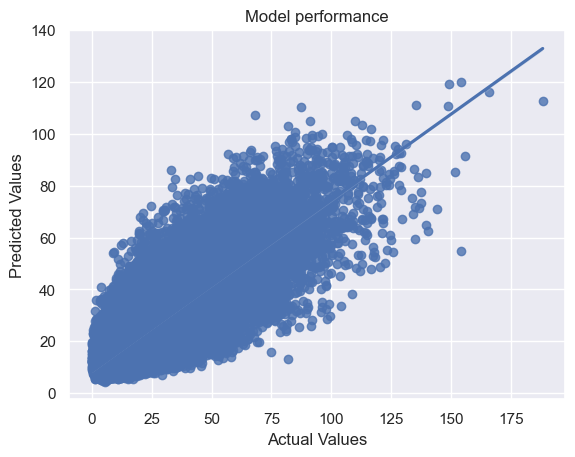

9.925

In [39]:
def evaluate(data,target,groups,model,plot=True):
    x=data.drop([],axis=1).reset_index(drop=True)
    y=target.reset_index(drop=True)
    random_states=[1]#[42,1,1234,1082,79,8,1081,99,742,10]
    oof = y.copy()
    scores=[]
    cv =GroupKFold(n_splits=10)
    for i,(trainidx,testidx) in enumerate(cv.split(x,y,groups=groups)):
        Xtrain,Xtest=x.iloc[trainidx],x.iloc[testidx]
        Ytrain,Ytest=y[trainidx],y[testidx]

        model.fit(Xtrain,Ytrain)

        pred=model.predict(Xtest)
        oof[testidx] = pred

        Score=metric(Ytest,pred,squared=False)
        scores.append(Score)
        print(
            f'Fold {i} :',
            f'Score :{np.round(Score,3)}',
            f'Training Groups :{groups[trainidx].nunique()} ',
            f'Test Groups :{groups[testidx].nunique()} ',
        )

    RMSE=np.mean(scores)
    print('scores mean :',np.round(RMSE,3),', std:',np.std(scores))
    if plot:
        sns.set()
        sns.regplot(x=y,y=oof)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Model performance')
        plt.show()
    return np.round(RMSE,3)

indexes=train.GT_NO2.dropna().index
model=LGBMRegressor(verbose=-1)

evaluate(
    data=train.loc[indexes,selected_columns],
    target=train.GT_NO2.iloc[indexes],
    groups=train.loc[indexes,'ID'].reset_index(drop=True).copy(),
    model=model,
)

In [8]:
train[num_cols].mean()

LAT                      45.421456
LON                      10.014272
Precipitation             2.585528
LST                     299.268841
AAI                      -1.274999
CloudFraction             0.200606
NO2_strat                 0.000045
NO2_total                 0.000156
NO2_trop                  0.000105
TropopausePressure    16655.112392
Date                    547.500000
Date_month                5.521898
Date_day                 14.732664
Date_week                25.645985
Date_year                 1.000000
dtype: float64

1. not filled:
* XGB :9.95
* LGBM :10.11
* CB :9.7

* filled wih mean:
* XGB :9.79
* LGBM :10.09
* CB :9.6

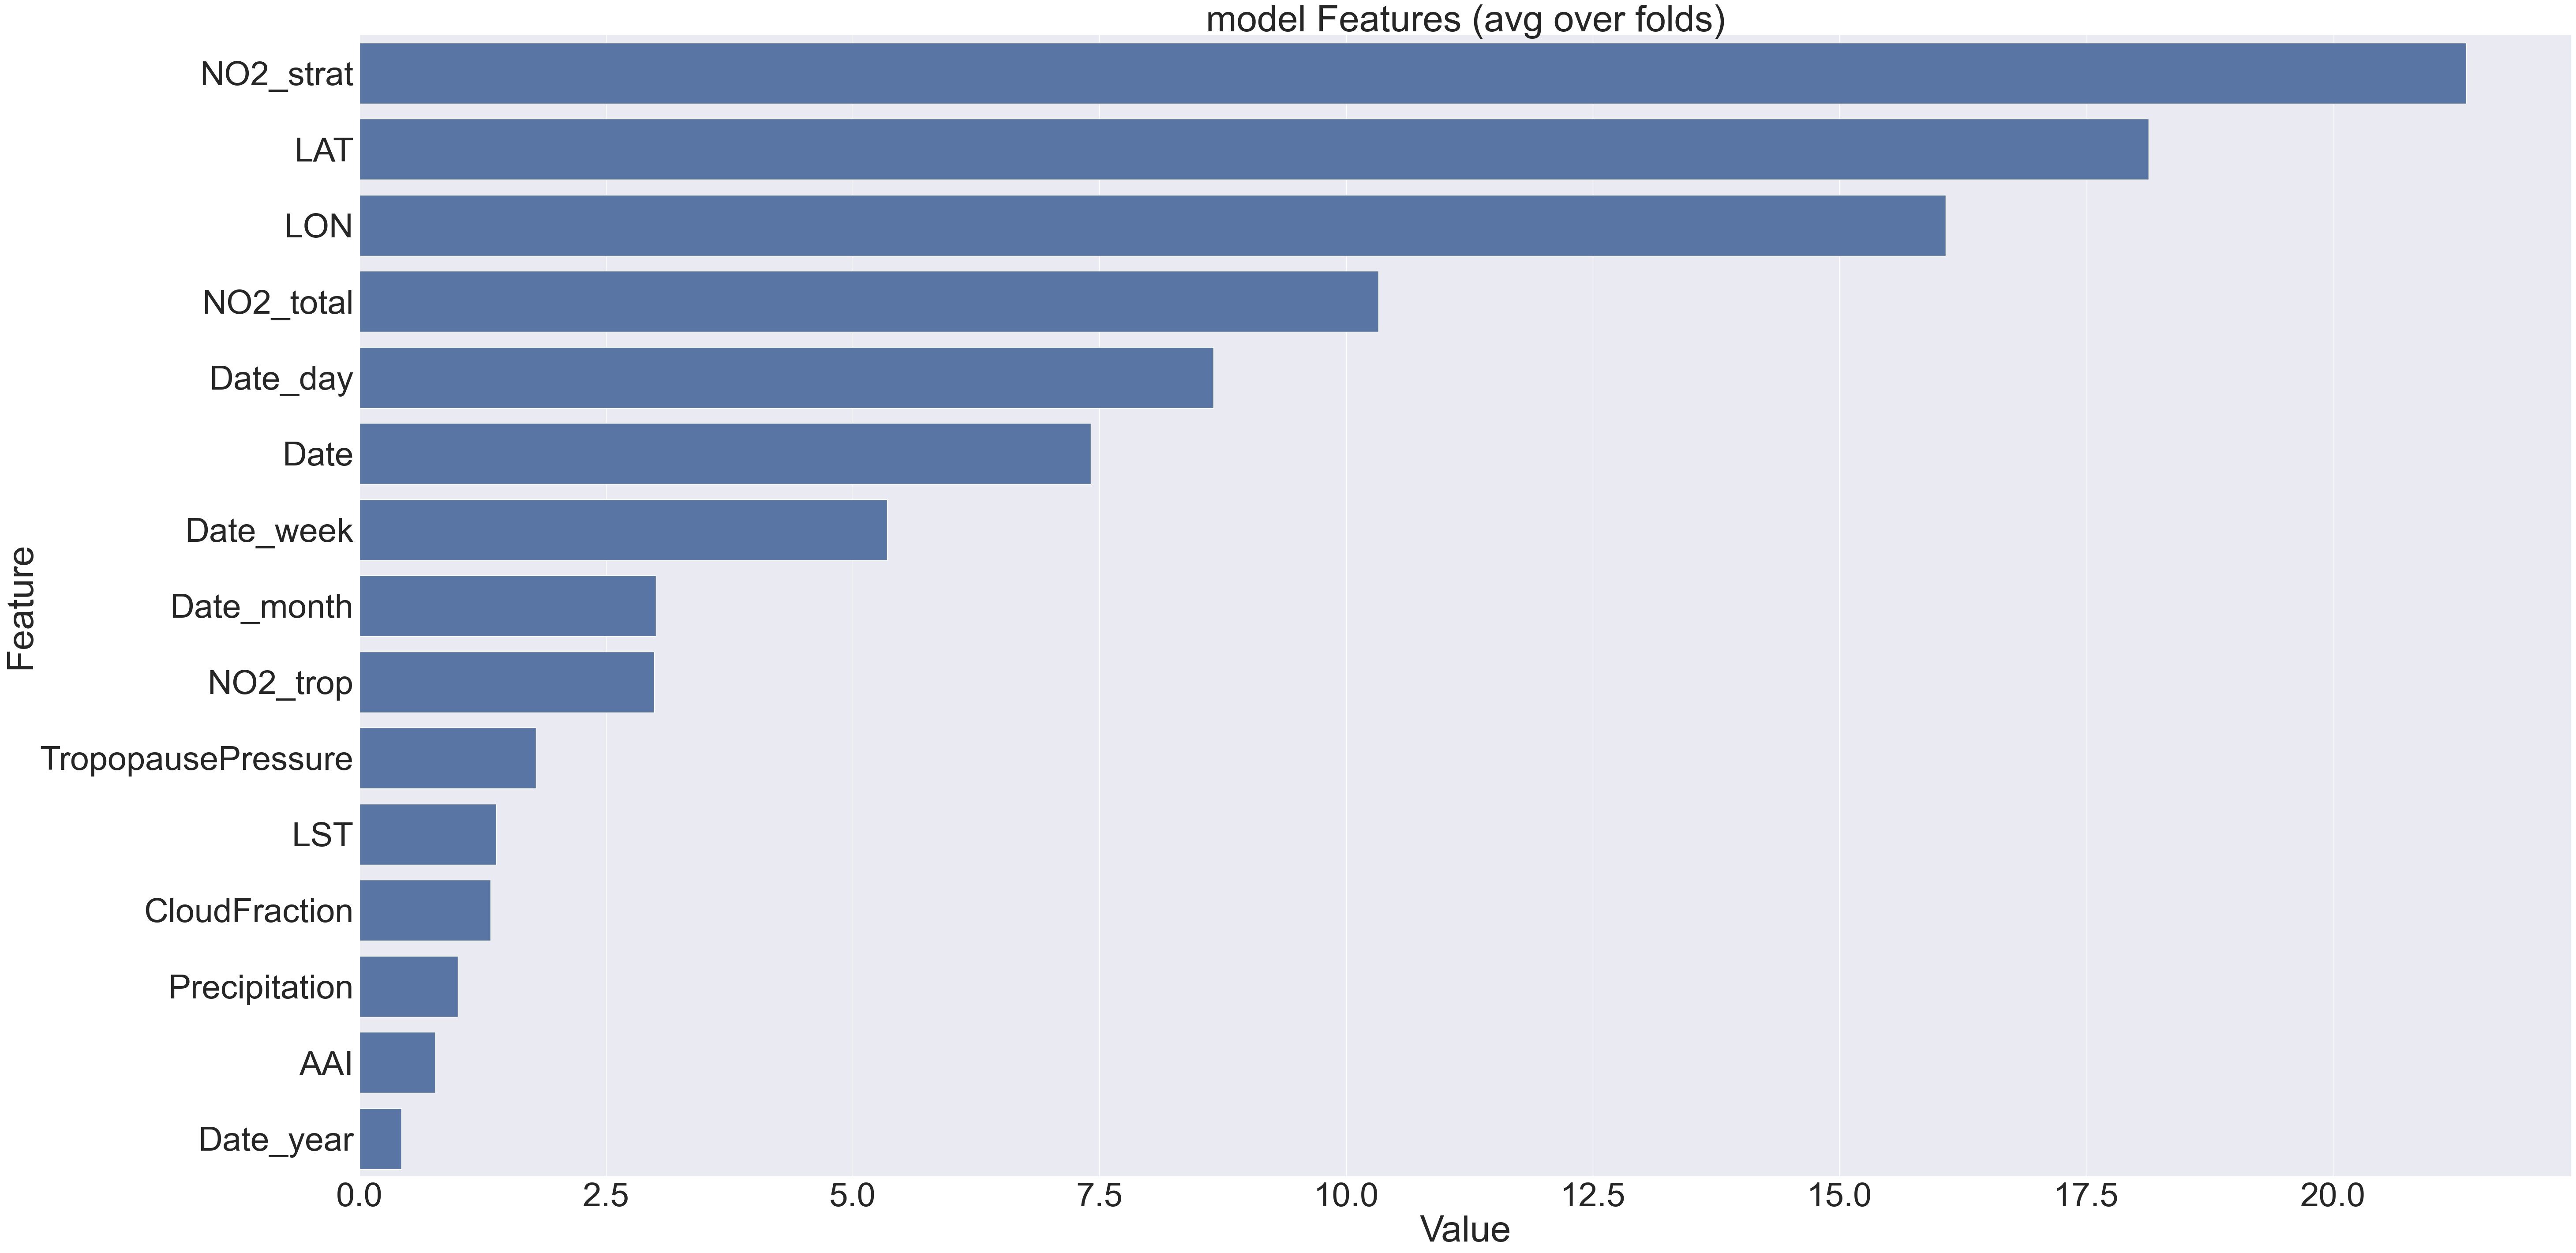

,Value,Feature
6,21.352747,NO2_strat
0,18.133511,LAT
1,16.077874,LON
7,10.328545,NO2_total
12,8.657379,Date_day
10,7.411536,Date
13,5.348675,Date_week
11,3.003793,Date_month
8,2.986374,NO2_trop
9,1.787747,TropopausePressure


In [72]:
def plotImp(model, X , num = 35, fig_size = (60, 30)):
    import pandas as pd
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('model Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('cb_importances-01.png')
    plt.show()
    return feature_imp.sort_values(by="Value",ascending=False)

model.fit(train.loc[indexes,selected_columns],train.GT_NO2.iloc[indexes])
plotImp(model,train.loc[indexes,num_cols])

In [20]:
train.describe(include='object')

,ID_Zindi,Date,ID
count,86584,86584,86584
unique,86582,1096,79
top,ID_ZHFIGQ,1/1/2019,PD01
freq,2,79,1096


In [39]:
indexes=train.GT_NO2.dropna().index
x=train.loc[indexes,selected_columns].drop([],axis=1).reset_index(drop=True).copy()
xtest=test[selected_columns]
y=train.GT_NO2.iloc[indexes].reset_index(drop=True).copy()

groups=train.loc[indexes,'ID'].reset_index(drop=True).copy()
oof = y.copy()

model=LGBMRegressor(verbose=-1)

scores=[]
total_preds=[]
cv =GroupKFold(n_splits=12)
for i,(trainidx,testidx) in enumerate(cv.split(x,y,groups=groups)):
    Xtrain,Xtest=x.iloc[trainidx],x.iloc[testidx]
    Ytrain,Ytest=y[trainidx],y[testidx]
    
    model.fit(Xtrain,Ytrain)
    pred=model.predict(Xtest)
    oof[testidx] = pred
    
    Score=metric(Ytest,pred,squared=False)
    scores.append(Score)

    total_preds.append(model.predict(xtest))
    
    
    print(
        f'Fold {i} :',
        f'Score :{np.round(Score,3)}',
        f'Training Groups :{groups[trainidx].nunique()} ',
        f'Test Groups :{groups[testidx].nunique()} ',
    )

test_preds_combined=np.mean(total_preds,axis=0)
RMSE=np.mean(scores)
print('average rmse :',np.round(RMSE,3),', std:',np.std(scores))

Fold 0 : Score :11.304 Training Groups :72  Test Groups :7 
Fold 1 : Score :11.264 Training Groups :72  Test Groups :7 
Fold 2 : Score :9.639 Training Groups :73  Test Groups :6 
Fold 3 : Score :9.561 Training Groups :73  Test Groups :6 
Fold 4 : Score :11.108 Training Groups :73  Test Groups :6 
Fold 5 : Score :10.517 Training Groups :73  Test Groups :6 
Fold 6 : Score :11.332 Training Groups :72  Test Groups :7 
Fold 7 : Score :9.423 Training Groups :73  Test Groups :6 
Fold 8 : Score :10.812 Training Groups :72  Test Groups :7 
Fold 9 : Score :12.981 Training Groups :72  Test Groups :7 
Fold 10 : Score :10.37 Training Groups :72  Test Groups :7 
Fold 11 : Score :9.878 Training Groups :72  Test Groups :7 
average rmse : 10.682 , std: 0.9718352716374108


In [11]:
test.isnull().sum()

ID_Zindi                 0
Date                     0
ID                       0
LAT                      0
LON                      0
Precipitation            0
LST                   2981
AAI                    868
CloudFraction          868
NO2_strat              868
NO2_total              868
NO2_trop              2578
TropopausePressure     868
Date_month               0
Date_day                 0
Date_week                0
Date_year                0
dtype: int64

# SUBMISSION

In [12]:
x=train.loc[indexes,selected_columns].drop([],axis=1).reset_index(drop=True)
xtest=test[selected_columns]
y=train.GT_NO2.iloc[indexes].reset_index(drop=True).copy()
model=XGBRegressor(verbose=-1)

model.fit(x,y)

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [05:13:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
predictions=model.predict(xtest)

#predictions=test_preds_combined

sub=pd.DataFrame(
    {
        'ID_Zindi':test.ID_Zindi,
        'GT_NO2':predictions
    }
)
sub

,ID_Zindi,GT_NO2
0,ID_2MYNQS,36.993690
1,ID_P4U5WU,36.629524
2,ID_U4KWPK,36.978348
3,ID_QGSNTZ,19.110672
4,ID_GHSZ6K,37.219635
...,...,...
6571,ID_GUSXU9,33.546574
6572,ID_GMVEG1,41.145683
6573,ID_GD6HNP,24.149286
6574,ID_J7YW1Y,39.688843


In [14]:
sub_name='XGB_FILLED_MEAN_9.97.csv'
sub.to_csv(PATH.submission + sub_name,index=False)

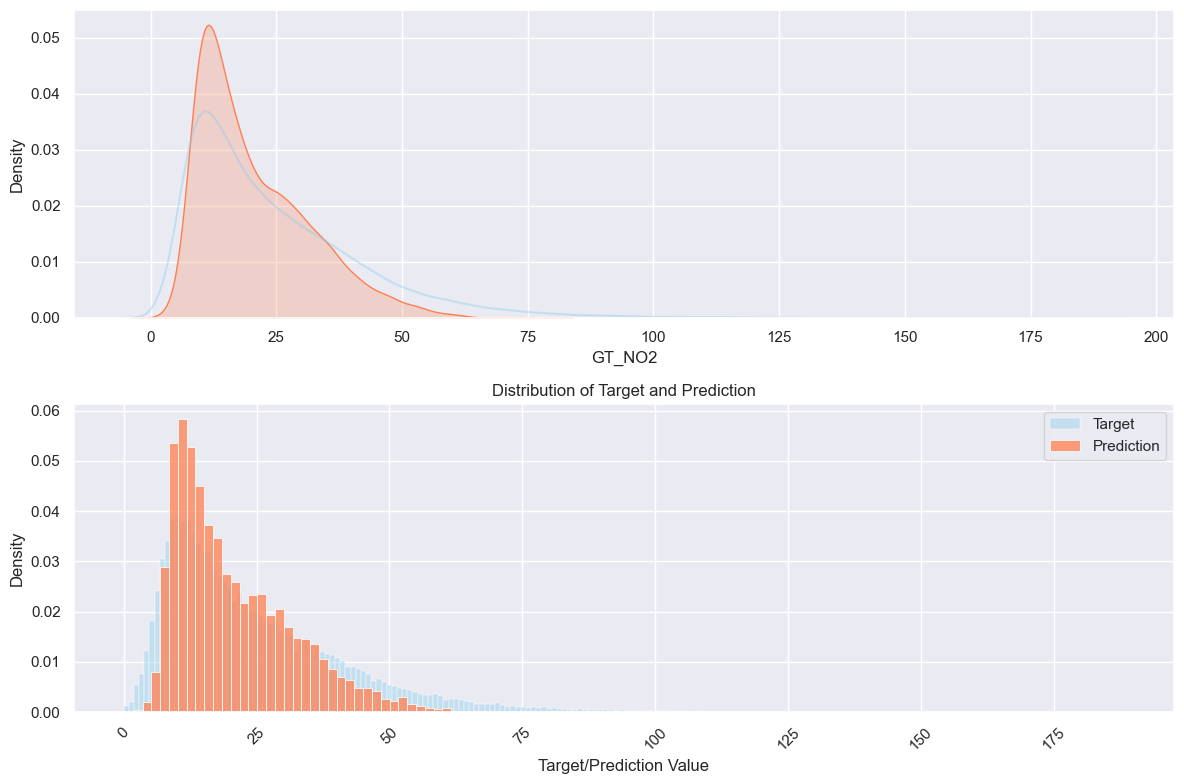

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

target=train.GT_NO2.iloc[indexes]

# Assuming you have your target and prediction data in separate NumPy arrays
# Replace with your target data
prediction = predictions  # Replace with your prediction data
# Create the figure and set a wider width for better visualization
fig,ax =plt.subplots(2,1,figsize=(12, 8))
sns.set()

# Plot the target distribution as a histogram with transparency
sns.kdeplot(target, label='Target', alpha=0.4, color='skyblue',ax=ax[0])
sns.histplot(target, label='Target',stat="density", alpha=0.4, color='skyblue',ax =ax[1])

# Overlay the prediction distribution as a density plot with a different color
sns.kdeplot(prediction, label='Prediction', fill=True, color='coral',ax=ax[0])
sns.histplot(prediction, label='Prediction',stat="density", fill=True, color='coral',ax=ax[1])

# Customize the plot for clarity and aesthetics
plt.title('Distribution of Target and Prediction')
plt.xlabel('Target/Prediction Value')
plt.ylabel('Density')
plt.legend()  # Add a legend to distinguish target and prediction

# Rotate x-axis labels for better readability if needed (optional)
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)  # Add a grid for visual reference (optional)
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()